# Connect Eye-AI and Load Libraries

In [1]:
# repo_dir = "Repos"   # Set this to be where your github repos are located.
# %load_ext autoreload
# %autoreload 2

# # Update the load path so python can find modules for the model
# import sys
# from pathlib import Path
# sys.path.insert(0, str(Path.home() / repo_dir / "eye-ai-ml"))
# sys.path.insert(0, str(Path.home() / repo_dir / "deriva-ml"))

In [2]:
# Prerequisites
import json
import os
from eye_ai.eye_ai import EyeAI

import pandas as pd
import numpy as np
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt
from pathlib import Path, PurePath
import logging

#from deriva_ml import DatasetBag, Workflow, ExecutionConfiguration
from deriva_ml import DerivaML, Workflow, ExecutionConfiguration, VersionPart
from deriva_ml import MLVocab as vc
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s', force=True)

2025-04-22 08:49:20.461394: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-22 08:49:20.461449: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-22 08:49:20.622837: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-22 08:49:20.971247: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-22 08:49:22.835565: W tensorflow/compiler/tf2

In [3]:
# Login
from deriva.core.utils.globus_auth_utils import GlobusNativeLogin
host = 'www.eye-ai.org'
#host = 'dev.eye-ai.org' #for dev testing
catalog_id = "eye-ai"

gnl = GlobusNativeLogin(host=host)
if gnl.is_logged_in([host]):
    print("You are already logged in.")
else:
    gnl.login([host], no_local_server=True, no_browser=True, refresh_tokens=True, update_bdbag_keychain=True)
    print("Login Successful")

2025-04-22 08:49:24,652 - INFO - Creating client of type <class 'globus_sdk.services.auth.client.native_client.NativeAppAuthClient'> for service "auth"
2025-04-22 08:49:24,653 - INFO - Finished initializing AuthLoginClient. client_id='8ef15ba9-2b4a-469c-a163-7fd910c9d111', type(authorizer)=<class 'globus_sdk.authorizers.base.NullAuthorizer'>
2025-04-22 08:49:24,654 - INFO - Setting up RefreshTokenAuthorizer with auth_client=[instance:139946649010864]
2025-04-22 08:49:24,655 - INFO - Setting up a RenewingAuthorizer. It will use an auth type of Bearer and can handle 401s.
2025-04-22 08:49:24,656 - INFO - RenewingAuthorizer will start by using access_token with hash "aa3eb3b37e3a9b153cf2ba9468f8931be183fc3b8bfa27b0ac0cf7fa203201b0"
2025-04-22 08:49:24,656 - INFO - Executing token refresh without client credentials
2025-04-22 08:49:24,657 - INFO - Fetching new token from Globus Auth
2025-04-22 08:49:25,070 - INFO - request done (success)
2025-04-22 08:49:25,070 - INFO - RenewingAuthorizer.

You are already logged in.


# Configuration

In [88]:
cache_dir = '/data'
working_dir = '/data'
EA = EyeAI(hostname = host, catalog_id = catalog_id, cache_dir= cache_dir, working_dir=working_dir)

2025-04-22 09:48:16,489 - INFO - Creating client of type <class 'globus_sdk.services.auth.client.native_client.NativeAppAuthClient'> for service "auth"
2025-04-22 09:48:16,490 - INFO - Finished initializing AuthLoginClient. client_id='8ef15ba9-2b4a-469c-a163-7fd910c9d111', type(authorizer)=<class 'globus_sdk.authorizers.base.NullAuthorizer'>


In [89]:

source_dataset = "2-277G"  #"2-N93J"
asset_RID = ["2-C8JM"]
ml_instance = DerivaML(host, catalog_id="eye-ai")

#ml_instance.increment_dataset_version(dataset_rid='2-277M', component= VersionPart.patch, description='Update to latest deriva-ml schema')

preds_workflow = EA.add_workflow( 
    Workflow(
        name="LAC data template",
        url="https://github.com/informatics-isi-edu/eye-ai-exec/blob/main/notebooks/Sandbox_KB/Get_VGGPreds.ipynb",
        workflow_type="Test Workflow",
        )
    )

config = ExecutionConfiguration(
    datasets=[
        {
            "rid": source_dataset,
            "materialize": False,
            "version": ml_instance.dataset_version(source_dataset),
        }
    ],
    assets=asset_RID,
    workflow=preds_workflow,
    description="Instance of linking VGG19 predictions to patient-level data",
    )

exec = ml_instance.create_execution(config)

2025-04-22 09:48:19,245 - INFO - Creating client of type <class 'globus_sdk.services.auth.client.native_client.NativeAppAuthClient'> for service "auth"
2025-04-22 09:48:19,246 - INFO - Finished initializing AuthLoginClient. client_id='8ef15ba9-2b4a-469c-a163-7fd910c9d111', type(authorizer)=<class 'globus_sdk.authorizers.base.NullAuthorizer'>
2025-04-22 09:48:20,062 - INFO - Execution Aborted
2025-04-22 09:48:20,344 - INFO - Materialize bag 2-277G... 
2025-04-22 09:48:20,447 - INFO - Creating client of type <class 'globus_sdk.services.auth.client.native_client.NativeAppAuthClient'> for service "auth"
2025-04-22 09:48:20,447 - INFO - Finished initializing AuthLoginClient. client_id='8ef15ba9-2b4a-469c-a163-7fd910c9d111', type(authorizer)=<class 'globus_sdk.authorizers.base.NullAuthorizer'>
2025-04-22 09:48:21,752 - INFO - Loading /home/kb_766/deriva-ml/cache/2-277G_8fc06e83a45cb181fa6ef92e65fa01c13ffbbdaa1ad35be99891ba6065529ad6/Dataset_2-277G
2025-04-22 09:48:27,943 - INFO - Creating ne

In [8]:
print(exec)

caching_dir: /home/kb_766/deriva-ml/cache
_working_dir: /home/kb_766/deriva-ml/DerivaML_working
execution_rid: 4-WKNC
workflow_rid: 4-M4TT
asset_paths: {'Execution_Asset': [AssetFilePath('/home/kb_766/deriva-ml/DerivaML_working/deriva-ml/execution/4-WKNC/downloaded-assets/Execution_Asset/predictions_results.csv')]}
configuration: datasets=[DatasetSpec(rid='2-277G', materialize=False, version=DatasetVersion(major=4, minor=5, patch=0))] assets=['2-C8JM'] workflow='4-M4TT' parameters={} description='Instance of linking VGG19 predictions to patient-level data' argv=['/home/kb_766/.conda/envs/my-tensorflow-conda/lib/python3.10/site-packages/ipykernel_launcher.py', '-f', '/home/kb_766/.local/share/jupyter/runtime/kernel-d082dc94-081c-482b-8ddc-e6e8eac9b06d.json']


In [90]:
# my test


ds_bag = exec.datasets[0]
imageDF = ds_bag.get_table_as_dataframe('Image_Diagnosis')
angle2DF = EA.filter_angle_2( ds_bag )
trainDF = EA.image_tall(ds_bag, 'Initial Diagnosis')


In [91]:
mergeDF = pd.merge( angle2DF, imageDF[imageDF['Diagnosis_Tag'] == 'Initial Diagnosis'],
                  how = 'left', left_on = 'RID', right_on = 'Image')

mergeDF['Diagnosis_Image'].value_counts()

Diagnosis_Image
No Glaucoma           5694
Suspected Glaucoma    3817
Name: count, dtype: int64

In [92]:
mergeDF.shape

(9511, 31)

In [ ]:
imageDF[imageDF['Diagnosis_Tag'] == 'Initial Diagnosis'].loc[:,'Diagnosis_Image'].value_counts()


In [6]:
ds_bag = exec.datasets[0]

In [7]:
# Get expert consensus diagnosis
experts = ['Benjamin Xu', 'Brandon Wong', 'Van Nguyen']
dxExpertOG = EA.image_tall(ds_bag, 'AI_glaucomasuspect_test')
dxExpertOG = dxExpertOG[ dxExpertOG['Full_Name'].isin(experts) ]

ridStore = []
dxStore = []
cDxStore = []
cdrStore = []
byxStore = []
bwStore = []
vnStore = []

for id in list(dxExpertOG['Image_RID'].unique()):
    ridStore.append(id)
    dxTemp = dxExpertOG[ dxExpertOG['Image_RID'] == id ]
    byxStore.append( dxTemp[ dxTemp['Full_Name'] == 'Benjamin Xu' ].loc[:,'Diagnosis_Image'].iloc[0] )
    bwStore.append( dxTemp[ dxTemp['Full_Name'] == 'Brandon Wong' ].loc[:,'Diagnosis_Image'].iloc[0] )
    vnStore.append( dxTemp[ dxTemp['Full_Name'] == 'Van Nguyen' ].loc[:,'Diagnosis_Image'].iloc[0] )
    dxCDR = dxTemp[dxTemp['Cup_Disk_Ratio'].apply(type) == float] 
    if len(dxCDR) > 0:
        cdrStore.append( round( dxCDR['Cup_Disk_Ratio'].sum() / len(dxCDR['Cup_Disk_Ratio']), 1 ) )
        if (dxTemp['Diagnosis_Image'] == 'Suspected Glaucoma').sum() > 1:
            dxStore.append('Suspected Glaucoma')
            cDxStore.append( (dxTemp['Diagnosis_Image'] == 'Suspected Glaucoma').sum() )
        else:
            dxStore.append('No Glaucoma')
            cDxStore.append( (dxTemp['Diagnosis_Image'] == 'No Glaucoma').sum() )
    else:
        cdrStore.append('')
        dxStore.append('Not Graded, Bad Quality')
        cDxStore.append(3)

dxExpert = pd.DataFrame({'RID_Image':ridStore, 'Diagnosis_Image_Expert':dxStore, 'Diagnosis_Image_Expert_Count':cDxStore, 'Diagnosis_BYX':byxStore, 'Diagnosis_BW':bwStore, 'Diagnosis_VN':vnStore, 'CDR_Expert':cdrStore})

In [8]:
# Function to update column names
pd.options.mode.copy_on_write = True
def updateCols(df, cols, colDict):
    df = df[cols]
    df.rename( columns = colDict, inplace = True )
    for c in set(cols).intersection( set(colDict) ): cols[cols.index(c)] = colDict.get(c)
    return df

cols = ['Image', 'Diagnosis_Image_Optom', 'Diagnosis_Image_CNN']
colDict = {'Image':'RID_Image', 'Observation':'RID_Observation', 'Subject':'RID_Subject'}

# Build up diagnosis DF for Optom and CNN
diags = ds_bag.get_table_as_dataframe('Image_Diagnosis')
diags = pd.merge( diags[diags['Execution'] == '2-C6E0'],
                   diags[diags['Diagnosis_Tag'] == 'Initial Diagnosis'],
                   on = 'Image', how = 'left', suffixes = ['_CNN', '_Optom'])

diags = updateCols( diags, cols, colDict )
del(cols[0])
cols[:0] = ['RID_Image', 'Diagnosis_Image_Expert', 'Diagnosis_Image_Expert_Count', 'Diagnosis_BYX', 'Diagnosis_BW', 'Diagnosis_VN', 'CDR_Expert']

# Merge onto diagnosis DF for Expert
diags = pd.merge( dxExpert, diags, on = 'RID_Image', how = 'left' )

# Link to image data
linkdDF = pd.merge( ds_bag.get_table_as_dataframe('Image'),
                  diags,
                  left_on = 'RID', right_on = 'RID_Image', 
                  how = 'right')

cols[:0] = ['Observation', 'Image_Side']
linkdDF = updateCols( linkdDF, cols, colDict )

# Link to observation data
linkdDF = pd.merge( ds_bag.get_table_as_dataframe('Observation'),
                   linkdDF,
                   left_on = 'RID', right_on = 'RID_Observation', 
                   how = 'right')

cols[:0] = ['Subject', 'date_of_encounter', 'Age', 'hba1c', 'dr_level', 'glaucoma_hx', 'consultant', 'Subject_image_quality']  # removed site_mrn
linkdDF = updateCols( linkdDF, cols, colDict )

# Link to subject data
linkdDF = pd.merge( ds_bag.get_table_as_dataframe('Subject'),
                   linkdDF,
                   left_on = 'RID', right_on = 'RID_Subject', 
                   how = 'right')

cols[:0] = ['RID_Subject', 'Subject_Gender', 'Subject_Ethnicity']  # removed site_mrn
del(cols[ np.where( np.array(cols)=='RID_Subject' )[0][1] ]) # remove duplicated RID_Subject
linkdDF = updateCols( linkdDF, cols, colDict )

In [9]:
# Get Predictions from Execution 2-C6E0 (VGG19 on test set)
preds = pd.read_csv(exec.asset_paths[0])

# Get RID Image from Filename
preds['Filename'] = preds['Filename'].apply(lambda x: x.split("_")[3].split(".")[0])

# Link back to full DF
linkdDF = pd.merge( linkdDF,
                   preds[['Filename', 'Probability Score']],
                   left_on = 'RID_Image', right_on = 'Filename', 
                   how = 'left')

cols.append('Probability Score')
colDict = {'Probability Score':'Diagnosis_CNN_Prob'}
linkdDF = updateCols( linkdDF, cols, colDict )

In [10]:
# Make a subject level DF
def getMaxDx(dxList):
    if (dxList == 'Suspected Glaucoma').sum() > 0:
        return 'Suspected Glaucoma'
    elif (dxList == 'Not Graded, Bad Quality').sum() > 0:
        return 'Not Graded, Bad Quality'
    else:
        return 'No Glaucoma'

def getMaxCDR(cdrList):
    t = [x for x in tempDF['CDR_Expert'] if isinstance(x, (int, float))]
    if len(t) > 0:
        return max(t)
    else:
        return ''

idList = []
genderList = []
ethnicityList = []
dxExpertList = []
cdrMaxList = []
dxOptomList = []
dxCNNList = []
probCNNList = []

for id in pd.unique( linkdDF['RID_Subject'] ):
    tempDF = linkdDF[ linkdDF['RID_Subject'] == id ]
    idList.append(id)
    genderList.append( tempDF['Subject_Gender'].iloc[0] )
    ethnicityList.append( tempDF['Subject_Ethnicity'].iloc[0] )
    dxExpertList.append( getMaxDx( tempDF['Diagnosis_Image_Expert'] ) )
    cdrMaxList.append( getMaxCDR( tempDF['CDR_Expert'] ) )
    dxOptomList.append( getMaxDx( tempDF['Diagnosis_Image_Optom'] ) )
    dxCNNList.append( getMaxDx( tempDF['Diagnosis_Image_CNN'] ) )
    probCNNList.append( tempDF['Diagnosis_CNN_Prob'].max() )

dxSubjectDF = pd.DataFrame({'RID_Subject':idList, 'Subject_Gender':genderList, 'Subject_Ethnicity':ethnicityList, 'Diagnosis_Image_Expert':dxExpertList, 'CDR_Expert':cdrMaxList, 'Diagnosis_Image_Optom':dxOptomList, 'Diagnosis_Image_CNN':dxCNNList, 'Diagnosis_CNN_Prob':probCNNList})


In [16]:
tempDF

,RID_Subject,Subject_Gender,Subject_Ethnicity,date_of_encounter,Age,hba1c,dr_level,glaucoma_hx,consultant,Subject_image_quality,...,RID_Image,Diagnosis_Image_Expert,Diagnosis_Image_Expert_Count,Diagnosis_BYX,Diagnosis_BW,Diagnosis_VN,CDR_Expert,Diagnosis_Image_Optom,Diagnosis_Image_CNN,Diagnosis_CNN_Prob
998,76KC,F,Latin American,2017-02-26,67,9.7,DR not determined,No,Sumavamsi Tiriveedhi,Insufficient for Full Interpretation,...,7R0C,Suspected Glaucoma,2,Suspected Glaucoma,No Glaucoma,Suspected Glaucoma,0.5,No Glaucoma,Suspected Glaucoma,0.876154
999,76KC,F,Latin American,2017-02-26,67,9.7,DR not determined,No,Sumavamsi Tiriveedhi,Insufficient for Full Interpretation,...,7R0J,Suspected Glaucoma,3,Suspected Glaucoma,Suspected Glaucoma,Suspected Glaucoma,0.7,No Glaucoma,Suspected Glaucoma,0.761446


In [12]:
np.unique( dxSubjectDF['Subject_Ethnicity'], return_counts=True )

(array(['African Descent', 'Asian', 'Caucasian', 'Latin American', 'Other',
        'ethnicity not specified'], dtype=object),
 array([ 43,  26,  10, 353,  15,  53]))

##### DEFINE Parity Metrics

In [39]:
# Define functions for Parity Metrics

def glcRate(xTab):
    return (xTab.iloc[0,1] + xTab.iloc[1,1]) / xTab.to_numpy().sum()

def predPosRate(xTab):
    return (xTab.iloc[1,0] + xTab.iloc[1,1]) / xTab.to_numpy().sum()
    
def accuracy(xTab):
    return (xTab.iloc[0,0] + xTab.iloc[1,1]) / xTab.to_numpy().sum()

def tpr(xTab):
    return xTab.iloc[1,1] / (xTab.iloc[1,1] + xTab.iloc[0,1])

def tnr(xTab):
    return xTab.iloc[0,0] / (xTab.iloc[1,0] + xTab.iloc[0,0])

def fpr(xTab):
    return xTab.iloc[1,0] / (xTab.iloc[1,0] + xTab.iloc[0,0])

def fnr(xTab):
    return xTab.iloc[0,1] / (xTab.iloc[0,1] + xTab.iloc[1,1])

def getParityMetrics(matrixList):
    vals = { 'n':{}, 'glcRate':{}, 'accuracy':{}, 'tpr':{}, 'tnr':{}, 'fpr':{}, 'fnr':{} }
    for e in matrixList.keys():
        vals['n'][e] = matrixList[e].to_numpy().sum()
        vals['glcRate'][e] = glcRate( matrixList[e] )
        vals['accuracy'][e] = accuracy( matrixList[e] )
        vals['tpr'][e] = tpr( matrixList[e] )
        vals['tnr'][e] = tnr( matrixList[e] )
        vals['fpr'][e] = fpr( matrixList[e] )
        vals['fnr'][e] = fnr( matrixList[e] )
    return pd.DataFrame.from_dict(vals).transpose().loc[:,['All', 'Latin American', 'African Descent', 'Asian', 'Caucasian', 'ethnicity not specified', 'Other']]

def getParityMetrics2(factorSeries, dxSeriesPred, dxSeriesActual):
    tempDF = pd.DataFrame({ 'Factor': factorSeries, 'DxPred': dxSeriesPred, 'DxActual': dxSeriesActual })
    tempDF['DxPred'] = tempDF['DxPred'].astype('category')
    tempDF['DxActual'] = tempDF['DxActual'].astype('category')
    matrixList = {}
    matrixList['All'] = pd.crosstab( dxSeriesPred, dxSeriesActual )
    for e in pd.unique( factorSeries ):
        matrixList[e] = pd.crosstab( tempDF[ tempDF['Factor'] == e ]['DxPred'], tempDF[ tempDF['Factor'] == e ]['DxActual'], dropna=False )

    vals = { 'n':{}, 'glcRate':{}, 'predPosRate':{}, 'accuracy':{}, 'tpr':{}, 'tnr':{}, 'fpr':{}, 'fnr':{} }
    for e in matrixList.keys():
        vals['n'][e] = matrixList[e].to_numpy().sum()
        vals['glcRate'][e] = glcRate( matrixList[e] )
        vals['predPosRate'][e] = predPosRate( matrixList[e] )
        vals['accuracy'][e] = accuracy( matrixList[e] )
        vals['tpr'][e] = tpr( matrixList[e] )
        vals['tnr'][e] = tnr( matrixList[e] )
        vals['fpr'][e] = fpr( matrixList[e] )
        vals['fnr'][e] = fnr( matrixList[e] )
    return pd.DataFrame.from_dict(vals).transpose()#.loc[:,['All', 'Latin American', 'African Descent', 'Asian', 'Caucasian', 'ethnicity not specified', 'Other']]

# Make Plots

In [40]:
tempDF = dxSubjectDF[ dxSubjectDF['CDR_Expert'] != '' ]
parityDF = getParityMetrics2( tempDF['CDR_Expert'], tempDF['Diagnosis_Image_CNN'], tempDF['Diagnosis_Image_Optom'] )


# SCATTER PLOTS FOR METRICS vs. CDR  -----

# test = parityDF.loc['accuracy'].to_frame()
# inds = [x for x in test.index if x != 'All']
# test = test.loc[inds]
# test['CDR'] = test.index
# test = test.sort_values( by='CDR' )
# # test.plot.scatter( x='CDR', y='tnr')
# test.plot.line( x='CDR', y='accuracy' )

# test = parityDF.loc['n'][1:10].to_frame()
# test['CDR'] = test.index


# HISTOGRAM BY CDR ALL  -----

#plt.bar(test['CDR'], test['n'], width=0.05, align='center')


# HISTOGRAM BY CDR GROUPED BY ETHNICITY  -----

tempDF['Subject_Ethnicity'] = tempDF['Subject_Ethnicity'].astype('category')
cdrEthCounts = {}
for i in pd.unique( tempDF['CDR_Expert'] ):
    cdrEthCounts[i] = tempDF[ tempDF['CDR_Expert'] == i ]['Subject_Ethnicity'].value_counts()

test = cdrEthCounts[ list( cdrEthCounts )[0] ].to_frame(name=list( cdrEthCounts )[0])
for i in list( cdrEthCounts )[1:len(list( cdrEthCounts ))]:
    test = pd.concat([test, cdrEthCounts[i].to_frame(name=i)], axis=1)

test = test.transpose()
test['CDR'] = test.index

test = test.sort_values( by='CDR' )
test

# HISTOGRAM BY CDR GROUPED BY ETHNICITY AND NORMALIZED -----

# testNorm = test.copy()

# for i in [x for x in test.columns if x != 'CDR']:
#     testNorm[i] = test[i] / test[i].sum()

# test.plot(x='CDR', kind='bar', stacked=False).legend(bbox_to_anchor=(1.0, 1.0))

# fig, ax = plt.subplots(figsize=(8,6))
# tempDF.groupby('Subject_Ethnicity').plot.scatter( x='CDR_Expert', y='Diagnosis_CNN_Prob', ax=ax, color=

/tmp/ipykernel_29440/4131201880.py:16: RuntimeWarning: invalid value encountered in scalar divide
  return xTab.iloc[0,0] / (xTab.iloc[1,0] + xTab.iloc[0,0])
/tmp/ipykernel_29440/4131201880.py:19: RuntimeWarning: invalid value encountered in scalar divide
  return xTab.iloc[1,0] / (xTab.iloc[1,0] + xTab.iloc[0,0])
/tmp/ipykernel_29440/4131201880.py:13: RuntimeWarning: invalid value encountered in scalar divide
  return xTab.iloc[1,1] / (xTab.iloc[1,1] + xTab.iloc[0,1])
/tmp/ipykernel_29440/4131201880.py:22: RuntimeWarning: invalid value encountered in scalar divide
  return xTab.iloc[0,1] / (xTab.iloc[0,1] + xTab.iloc[1,1])


Subject_Ethnicity,Latin American,African Descent,ethnicity not specified,Asian,Other,Caucasian,CDR
0.1,3,0,0,0,0,0,0.1
0.2,26,1,4,2,0,1,0.2
0.3,44,4,8,2,2,4,0.3
0.4,53,6,6,6,1,1,0.4
0.5,65,3,9,3,4,2,0.5
0.6,75,8,9,6,3,1,0.6
0.7,57,15,8,5,2,1,0.7
0.8,23,3,7,2,2,0,0.8
0.9,6,3,2,0,1,0,0.9


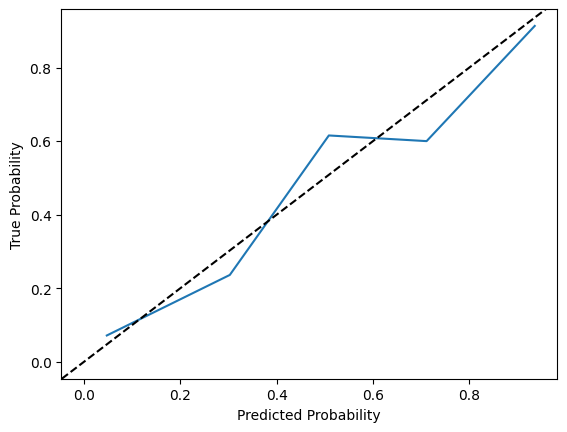

In [278]:
prob_true, prob_pred = calibration_curve(y_true=dxSubjectDF['Diagnosis_Image_Optom'], y_prob=dxSubjectDF['Diagnosis_CNN_Prob'], pos_label='Suspected Glaucoma', n_bins=5)
plt.plot(prob_pred,prob_true)
plt.xlabel('Predicted Probability')
plt.ylabel('True Probability')
plt.axline((0,0), slope=1, color='0.0', linestyle='--')
plt.show()

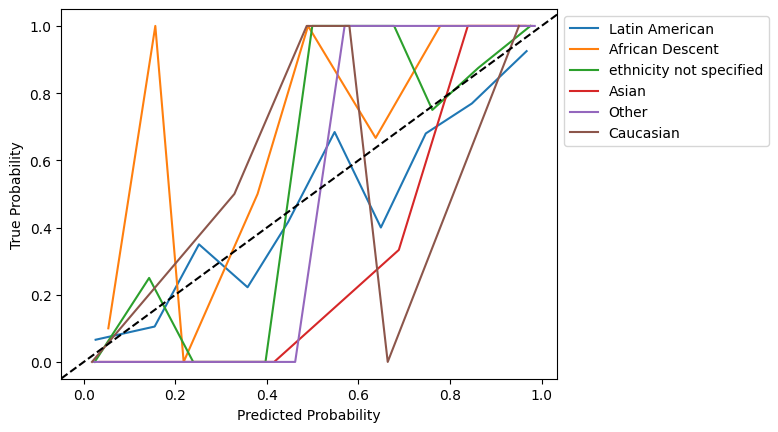

In [280]:
prob_true = {}
prob_pred = {}

# CALIBRATION CURVES GROUPED BY ETHNICITY

for e in ['Latin American', 'African Descent', 'ethnicity not specified', 'Asian', 'Other','Caucasian']:
    tempDF = dxSubjectDF[dxSubjectDF['Subject_Ethnicity'] == e]
    prob_true[e], prob_pred[e] = calibration_curve(y_true=tempDF['Diagnosis_Image_Optom'], y_prob=tempDF['Diagnosis_CNN_Prob'], pos_label='Suspected Glaucoma', n_bins=10)
    plt.plot(prob_pred[e],prob_true[e], label=e)


# CALIBRATION CURVES GROUPED BY GENDER

# for e in ['M', 'F']:
#     tempDF = dxSubjectDF[dxSubjectDF['Subject_Gender'] == e]
#     prob_true[e], prob_pred[e] = calibration_curve(y_true=tempDF['Diagnosis_Image_Optom'], y_prob=tempDF['Diagnosis_CNN_Prob'], pos_label='Suspected Glaucoma', n_bins=10)
#     plt.plot(prob_pred[e],prob_true[e], label=e)
    
plt.xlabel('Predicted Probability')
plt.ylabel('True Probability')
plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.axline((0,0), slope=1, color='0.0', linestyle='--')
plt.show()

# Calculate Parity Metrics at IMAGE Level

In [149]:
# Parity metrics for CNN vs. Optom
getParityMetrics2( linkdDF['Subject_Ethnicity'], linkdDF['Diagnosis_Image_CNN'], linkdDF['Diagnosis_Image_Optom'] )

,All,Other,Asian,African Descent,Latin American,ethnicity not specified,Caucasian
n,1000.000,30.000000,52.000000,86.000000,706.000000,106.000000,20.000000
glcRate,0.500,0.600000,0.461538,0.720930,0.467422,0.547170,0.400000
predPosRate,0.431,0.566667,0.384615,0.593023,0.407932,0.481132,0.200000
accuracy,0.807,0.966667,0.807692,0.848837,0.787535,0.877358,0.700000
tpr,0.738,0.944444,0.708333,0.806452,0.709091,0.827586,0.375000
tnr,0.876,1.000000,0.892857,0.958333,0.856383,0.937500,0.916667
fpr,0.124,0.000000,0.107143,0.041667,0.143617,0.062500,0.083333
fnr,0.262,0.055556,0.291667,0.193548,0.290909,0.172414,0.625000


In [150]:
# Parity metrics for CNN vs. Expert labels
expertGradedDF = linkdDF[linkdDF['Diagnosis_Image_Expert'] != 'Not Graded, Bad Quality']
getParityMetrics2( expertGradedDF['Subject_Ethnicity'], expertGradedDF['Diagnosis_Image_CNN'], expertGradedDF['Diagnosis_Image_Expert'] )

,All,Other,Asian,African Descent,Latin American,ethnicity not specified,Caucasian
n,983.000000,30.000000,49.000000,86.000000,696.000000,102.000000,20.000000
glcRate,0.387589,0.533333,0.346939,0.569767,0.362069,0.431373,0.150000
predPosRate,0.437436,0.566667,0.408163,0.593023,0.412356,0.500000,0.200000
accuracy,0.836216,0.833333,0.857143,0.860465,0.823276,0.872549,0.950000
tpr,0.853018,0.875000,0.882353,0.897959,0.825397,0.931818,1.000000
tnr,0.825581,0.785714,0.843750,0.810811,0.822072,0.827586,0.941176
fpr,0.174419,0.214286,0.156250,0.189189,0.177928,0.172414,0.058824
fnr,0.146982,0.125000,0.117647,0.102041,0.174603,0.068182,0.000000


In [151]:
# Parity metrics for Optom vs. Expert labels
getParityMetrics2( expertGradedDF['Subject_Ethnicity'], expertGradedDF['Diagnosis_Image_Optom'], expertGradedDF['Diagnosis_Image_Expert'] )

,All,Other,Asian,African Descent,Latin American,ethnicity not specified,Caucasian
n,983.000000,30.000000,49.000000,86.000000,696.000000,102.000000,20.000000
glcRate,0.387589,0.533333,0.346939,0.569767,0.362069,0.431373,0.150000
predPosRate,0.504578,0.600000,0.469388,0.720930,0.471264,0.558824,0.400000
accuracy,0.767040,0.866667,0.836735,0.779070,0.741379,0.872549,0.750000
tpr,0.850394,0.937500,0.941176,0.938776,0.793651,1.000000,1.000000
tnr,0.714286,0.785714,0.781250,0.567568,0.711712,0.775862,0.705882
fpr,0.285714,0.214286,0.218750,0.432432,0.288288,0.224138,0.294118
fnr,0.149606,0.062500,0.058824,0.061224,0.206349,0.000000,0.000000


# Calculate Parity Metrics at SUBJECT Level

In [152]:
# Parity metrics for CNN vs. Optom
getParityMetrics2( dxSubjectDF['Subject_Ethnicity'], dxSubjectDF['Diagnosis_Image_CNN'], dxSubjectDF['Diagnosis_Image_Optom'] )

,All,Other,Asian,African Descent,Latin American,ethnicity not specified,Caucasian
n,500.000,15.0,26.000000,43.000000,353.000000,53.000000,10.000000
glcRate,0.500,0.6,0.461538,0.720930,0.467422,0.547170,0.400000
predPosRate,0.522,0.6,0.538462,0.651163,0.504249,0.547170,0.300000
accuracy,0.846,1.0,0.923077,0.883721,0.821530,0.924528,0.700000
tpr,0.868,1.0,1.000000,0.870968,0.848485,0.931034,0.500000
tnr,0.824,1.0,0.857143,0.916667,0.797872,0.916667,0.833333
fpr,0.176,0.0,0.142857,0.083333,0.202128,0.083333,0.166667
fnr,0.132,0.0,0.000000,0.129032,0.151515,0.068966,0.500000


In [153]:
# Parity metrics for CNN vs. Expert labels
expertGradedDF = dxSubjectDF[dxSubjectDF['Diagnosis_Image_Expert'] != 'Not Graded, Bad Quality']
getParityMetrics2( expertGradedDF['Subject_Ethnicity'], expertGradedDF['Diagnosis_Image_CNN'], expertGradedDF['Diagnosis_Image_Expert'] )

,All,Other,Asian,African Descent,Latin American,ethnicity not specified,Caucasian
n,486.000000,15.000000,24.000000,43.000000,345.000000,49.000000,10.000
glcRate,0.506173,0.600000,0.500000,0.674419,0.486957,0.530612,0.200
predPosRate,0.530864,0.600000,0.583333,0.651163,0.510145,0.571429,0.300
accuracy,0.860082,0.866667,0.833333,0.976744,0.837681,0.918367,0.900
tpr,0.886179,0.888889,0.916667,0.965517,0.857143,0.961538,1.000
tnr,0.833333,0.833333,0.750000,1.000000,0.819209,0.869565,0.875
fpr,0.166667,0.166667,0.250000,0.000000,0.180791,0.130435,0.125
fnr,0.113821,0.111111,0.083333,0.034483,0.142857,0.038462,0.000


In [154]:
# Parity metrics for Optom vs. Expert labels
getParityMetrics2( expertGradedDF['Subject_Ethnicity'], expertGradedDF['Diagnosis_Image_Optom'], expertGradedDF['Diagnosis_Image_Expert'] )

,All,Other,Asian,African Descent,Latin American,ethnicity not specified,Caucasian
n,486.000000,15.000000,24.000000,43.000000,345.000000,49.000000,10.00
glcRate,0.506173,0.600000,0.500000,0.674419,0.486957,0.530612,0.20
predPosRate,0.510288,0.600000,0.500000,0.720930,0.475362,0.571429,0.40
accuracy,0.823045,0.866667,0.916667,0.860465,0.791304,0.959184,0.80
tpr,0.829268,0.888889,0.916667,0.931034,0.773810,1.000000,1.00
tnr,0.816667,0.833333,0.916667,0.714286,0.807910,0.913043,0.75
fpr,0.183333,0.166667,0.083333,0.285714,0.192090,0.086957,0.25
fnr,0.170732,0.111111,0.083333,0.068966,0.226190,0.000000,0.00


In [155]:



# Space to stop autoscroll




In [18]:
np.unique(linkdDF['consultant'], return_counts=True)

(array(['Alice Whang', 'Alicia Liu', 'Anna Tong', 'Esther Chung',
        'Gloria Wu', 'Ifeoma Ezeani', 'Jane Lo', 'John Shan',
        'Keith Allen Tio', 'Lauren Daskivich', 'Lesley Kwan',
        'Lucrecia Escobar', 'Mai Truong', 'Matthew Wang', 'Michelle Hoyt',
        'Naro Babaian Marukian', 'Ryan Vikesland', 'Sumavamsi Tiriveedhi',
        'Tina Zheng'], dtype=object),
 array([  8, 104, 100,  32,  82,   4,  38,  20,  46,   4,  64,  78,  56,
         46,   6,  68,  76, 148,  20]))

# Upload Results

In [15]:
# crete asset path
asset_type_name = "Diagnosis_Analysis"
asset_path = exec.execution_asset_path(asset_type_name)

# save assets to asset_path
linkdDF.to_csv(asset_path/'ImagesToVGG19.csv', index=False)
#dxSubjectDF.to_csv(asset_path/'SubjectsToVGG19.csv', index=False)
#parityMetrics.to_csv(asset_path/'ParityMetrics.csv', index=False)

# upload assets to catalog
exec.upload_execution_outputs(clean_folder=True)

2025-03-12 16:31:22,916 - INFO - Initializing uploader: GenericUploader v1.7.6 [Python 3.10.13, Linux-5.10.210-201.852.amzn2.x86_64-x86_64-with-glibc2.26]
2025-03-12 16:31:22,925 - INFO - Creating client of type <class 'globus_sdk.services.auth.client.native_client.NativeAppAuthClient'> for service "auth"
2025-03-12 16:31:22,928 - INFO - Finished initializing AuthLoginClient. client_id='8ef15ba9-2b4a-469c-a163-7fd910c9d111', type(authorizer)=<class 'globus_sdk.authorizers.base.NullAuthorizer'>
2025-03-12 16:31:22,975 - INFO - Scanning files in directory [/home/kb_766/deriva-ml/DerivaML_working/deriva-ml/execution/4-QABT]...
2025-03-12 16:31:22,981 - INFO - Including file: [/home/kb_766/deriva-ml/DerivaML_working/deriva-ml/execution/4-QABT/execution-metadata/Execution_Config/configuration.json].
2025-03-12 16:31:22,981 - INFO - Including file: [/home/kb_766/deriva-ml/DerivaML_working/deriva-ml/execution/4-QABT/execution-metadata/Runtime_Env/environment_snapshot_c0zwzpet.txt].
2025-03-12

{'Execution_Config/configuration.json': FileUploadState(state=<UploadState.success: 0>, status='Complete', result={'URL': '/hatrac/execution_metadata/6a07499e0d362b53a46a904484115afb.configuration.json:RUsEDHDARVkVFpySvcslCsfxhxraTXpw', 'RID': '4-S3K2', 'RCT': '2025-03-12T23:31:23.35516+00:00', 'RMT': '2025-03-12T23:31:23.35516+00:00', 'RCB': 'https://auth.globus.org/6022643c-876c-4a47-bafa-5b9fac2c7782', 'RMB': 'https://auth.globus.org/6022643c-876c-4a47-bafa-5b9fac2c7782', 'Filename': 'configuration.json', 'Description': None, 'Length': 226, 'MD5': '6a07499e0d362b53a46a904484115afb', 'Execution_Metadata_Type': 'Execution_Config'}, rid='4-S3K2'),
 'Runtime_Env/environment_snapshot_c0zwzpet.txt': FileUploadState(state=<UploadState.success: 0>, status='Complete', result={'URL': '/hatrac/execution_metadata/78cfaf7cfb43323f37693889acb3bf4c.environment_snapshot_c0zwzpet.txt:tJ0LndYvMNZA3mFjUKKL3TduBRvnsdlI', 'RID': '4-S3K4', 'RCT': '2025-03-12T23:31:23.587996+00:00', 'RMT': '2025-03-12T23: